In [177]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl

In [178]:
dirs = {}
dirs['source_images'] = '/home/alex/Data/Work/Sources/galaxy-zoo-the-galaxy-challenge/galzoo/small_sample'
#dirs['source_images'] = '/home/alex/Data/Work/Sources/galaxy-zoo-the-galaxy-challenge/images_training_rev1'

In [179]:
filenames = os.listdir(dirs['source_images'])
features_all = np.load('autoencoder_features_galaxyzoo.npy')

## Full images

In [180]:
idx = np.random.choice(features_all.shape[0], 500, replace=False)
filenames = np.array(os.listdir(dirs['source_images']))[idx]
features = features_all[idx, :]

In [181]:
print(len(filenames),features.shape)

500 (500, 64)


#### Visualize features

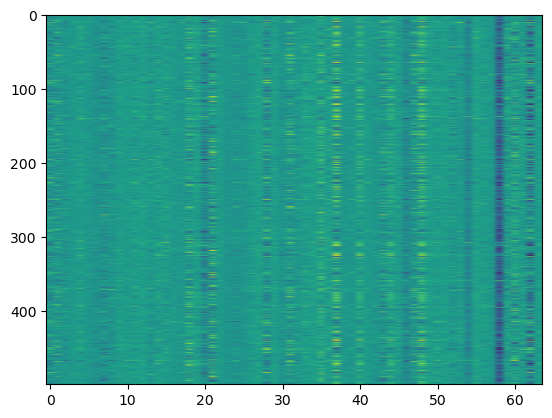

In [182]:
plt.imshow(features,aspect='auto')

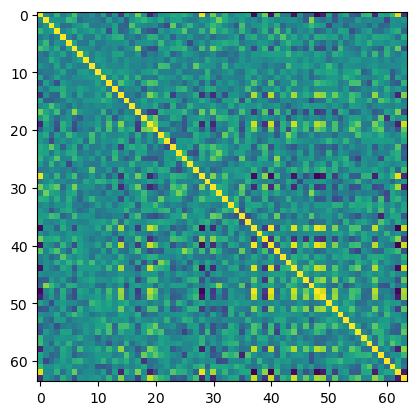

In [189]:
plt.imshow(np.corrcoef(features.T))

### Feature selection

In [155]:
from sklearn.feature_selection import VarianceThreshold

#### HDBScan clustering

In [18]:
hdb = skl.cluster.HDBSCAN(min_cluster_size=6)
hdb.fit(features)

,min_cluster_size,6
,min_samples,None
,cluster_selection_epsilon,0.0
,max_cluster_size,None
,metric,'euclidean'
,metric_params,None
,alpha,1.0
,algorithm,'auto'
,leaf_size,40
,n_jobs,None
,cluster_selection_method,'eom'


In [19]:
hdb.labels_

array([ 0,  0,  0, -1,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0, -1,  0, -1,  0,  0, -1,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,
        0, -1,  0, -1, -1,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,
       -1,  0,  1, -1, -1,  0,  0,  0, -1, -1,  0,  0, -1, -1,  0,  0,  0,
        0, -1, -1, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0, -1,
       -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0, -1, -1,  0,  0, -1,
        0,  1,  0,  0, -1, -1,  0,  0,  0,  0,  0, -1,  0, -1, -1,  0, -1,
        0,  0,  0,  0, -1,  0, -1, -1, -1, -1,  0,  0, -1,  0,  0,  0,  0,
       -1, -1,  0,  0,  0, -1, -1,  0,  0, -1, -1,  0,  0,  0,  0,  0, -1,
        0, -1,  0,  0,  0, -1,  1,  0,  0, -1, -1, -1,  0, -1, -1,  0,  0,
        0, -1,  0, -1,  0, -1,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0, -1, -1

In [21]:
sum(hdb.labels_==1)

np.int64(6)

In [38]:
hdb_features = features[hdb.labels_==3]
hdb_filenames = filenames[hdb.labels_==3]

#### tSNE embeddings

In [195]:
X_embedded = skl.manifold.TSNE(n_components=2, learning_rate='auto',
                  init='pca', perplexity=30,verbose=10,max_iter=1500).fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.502004
[t-SNE] Computed conditional probabilities in 0.010s
[t-SNE] Iteration 50: error = 60.2142906, gradient norm = 0.0073028 (50 iterations in 0.056s)
[t-SNE] Iteration 100: error = 58.8907547, gradient norm = 0.0022211 (50 iterations in 0.047s)
[t-SNE] Iteration 150: error = 58.8804398, gradient norm = 0.0054041 (50 iterations in 0.044s)
[t-SNE] Iteration 200: error = 58.8739243, gradient norm = 0.0092347 (50 iterations in 0.042s)
[t-SNE] Iteration 250: error = 58.8762703, gradient norm = 0.0044354 (50 iterations in 0.033s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.876270
[t-SNE] Iteration 300: error = 0.9392962, gradient norm = 0.0085536 (50 iterations in 0.040s)
[t-SNE] Iteration 350: error = 0.8738551, gradient norm = 0.0063337 (

In [196]:
X_embedded = pd.DataFrame(data=X_embedded,columns=['feat_1','feat_2'])

In [197]:
X_embedded['fnames'] = filenames

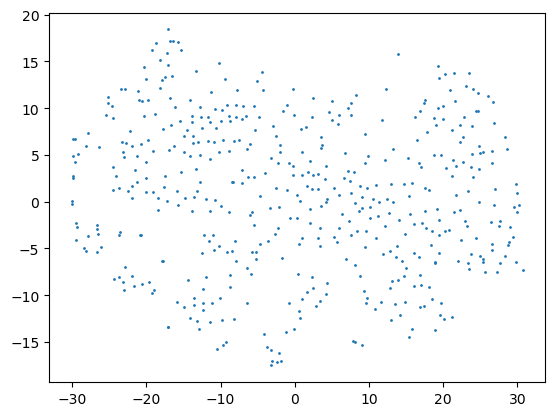

In [198]:
plt.scatter(X_embedded['feat_1'],X_embedded['feat_2'],s=1)

### Plot galaxies

In [1]:
def crop_image(image,cut_size=128):
    cut_val = (image.shape[0] - cut_size)//2
    image = image[cut_val:-cut_val,cut_val:-cut_val]
    return image

In [2]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def plot_embedding(X_embedded,zoom=0.2,figsize=(20,20),cut_size=128):
    x = X_embedded['feat_1']
    y = X_embedded['feat_2']
    filenames = X_embedded['fnames']
    fig, ax = plt.subplots(figsize=figsize)
    imscatter(x, y, filenames, zoom=zoom, ax=ax, cut_size=cut_size)
    #ax.plot(x, y)
    plt.show()

def imscatter(x, y, images, ax=None, zoom=1, cut_size = 128):
    if ax is None:
        ax = plt.gca()
    artists = []
    for x0, y0, imgpath in zip(x, y,images):
        image = plt.imread(os.path.join(dirs['source_images'],imgpath))
        image = crop_image(image,cut_size)
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

plot_embedding(X_embedded)

NameError: name 'X_embedded' is not defined

### Post-labelling with expert answers

In [168]:
classes = pd.read_csv('/home/alex/Data/Work/Sources/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.csv')

In [169]:
classes['GalaxyID'] = classes['GalaxyID'].astype('str')

In [170]:
X_embedded['GalaxyID'] = X_embedded['fnames'].str.replace('.jpg','')

<Axes: >

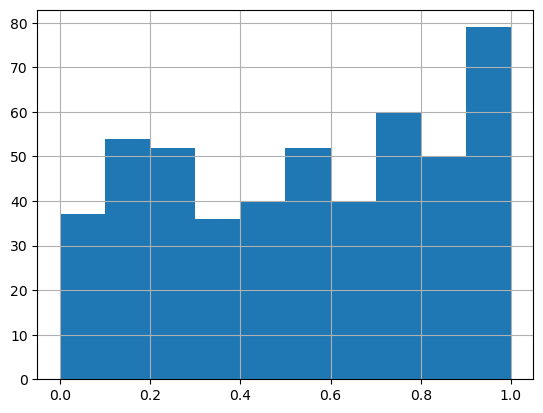

In [176]:
classes['Class1.2'].hist()

In [171]:
X_embedded.head()

,feat_1,feat_2,fnames,GalaxyID
0,14.337599,-5.464725,113267.jpg,113267
1,-17.002558,0.083419,101589.jpg,101589
2,-19.818516,-8.672704,113149.jpg,113149
3,17.035532,1.471290,107629.jpg,107629
4,21.943954,-7.835637,110746.jpg,110746


In [172]:
classes = pd.merge(classes,X_embedded,on='GalaxyID')

In [173]:
classes.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,feat_1,feat_2,fnames
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512,12.034018,-7.773481,100008.jpg
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000,-21.619183,-15.002141,100023.jpg
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-15.959188,2.148333,100053.jpg
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000,-17.510199,-3.607214,100078.jpg
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-4.855245,-11.221530,100090.jpg


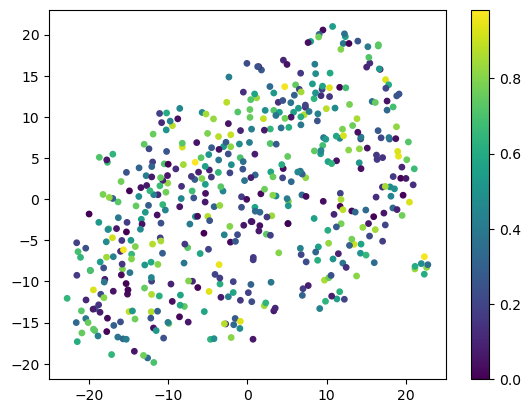

In [174]:
im = plt.scatter(classes['feat_1'],classes['feat_2'],s=15,c=classes['Class1.1'])
plt.colorbar(im)

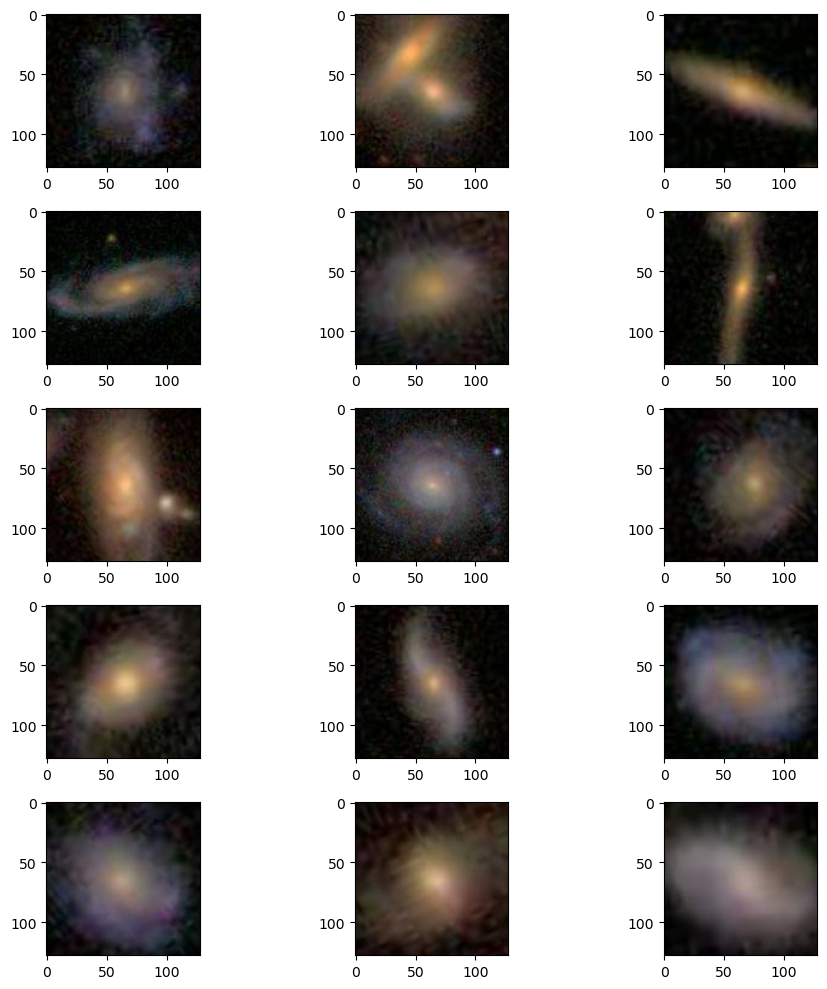

In [130]:
fig = plt.figure(figsize=(10,10))
files = classes[classes['Class1.1']<0.2]['fnames'].values
for i in range(15):
    ax = fig.add_subplot(5,3,i+1)
    image = plt.imread(os.path.join(dirs['source_images'],files[i]))
    image = crop_image(image)
    ax.imshow(image)
plt.tight_layout()

### Using tabular data

In [249]:
exp_features = classes[[c for c in classes.columns if ('Class' in c)]]

In [250]:
from sklearn.preprocessing import StandardScaler
exp_features = StandardScaler().fit_transform(exp_features)
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
exp_features = pca.fit_transform(exp_features)

In [251]:
X_embedded_exp = skl.manifold.TSNE(n_components=2, learning_rate='auto',
                  init='pca', perplexity=30).fit_transform(exp_features)

In [252]:
X_embedded_exp = pd.DataFrame(data=X_embedded_exp,columns=['feat_1','feat_2'])

In [253]:
X_embedded_exp['fnames'] = filenames

In [254]:
classes_exp = pd.merge(classes,X_embedded_exp,on='fnames')

In [255]:
classes_exp.columns

Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6', 'feat_1_x', 'feat_2_x', 'fnames',
       'feat_1_y', 'feat_2_y'],
      dtype='object')

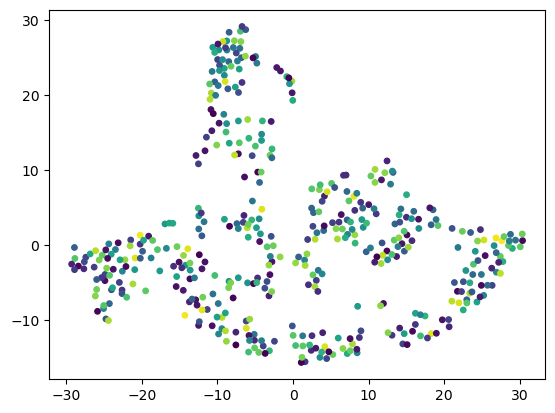

In [256]:
plt.scatter(classes_exp['feat_1_y'],classes_exp['feat_2_y'],s=15, c=classes_exp['Class1.1'])

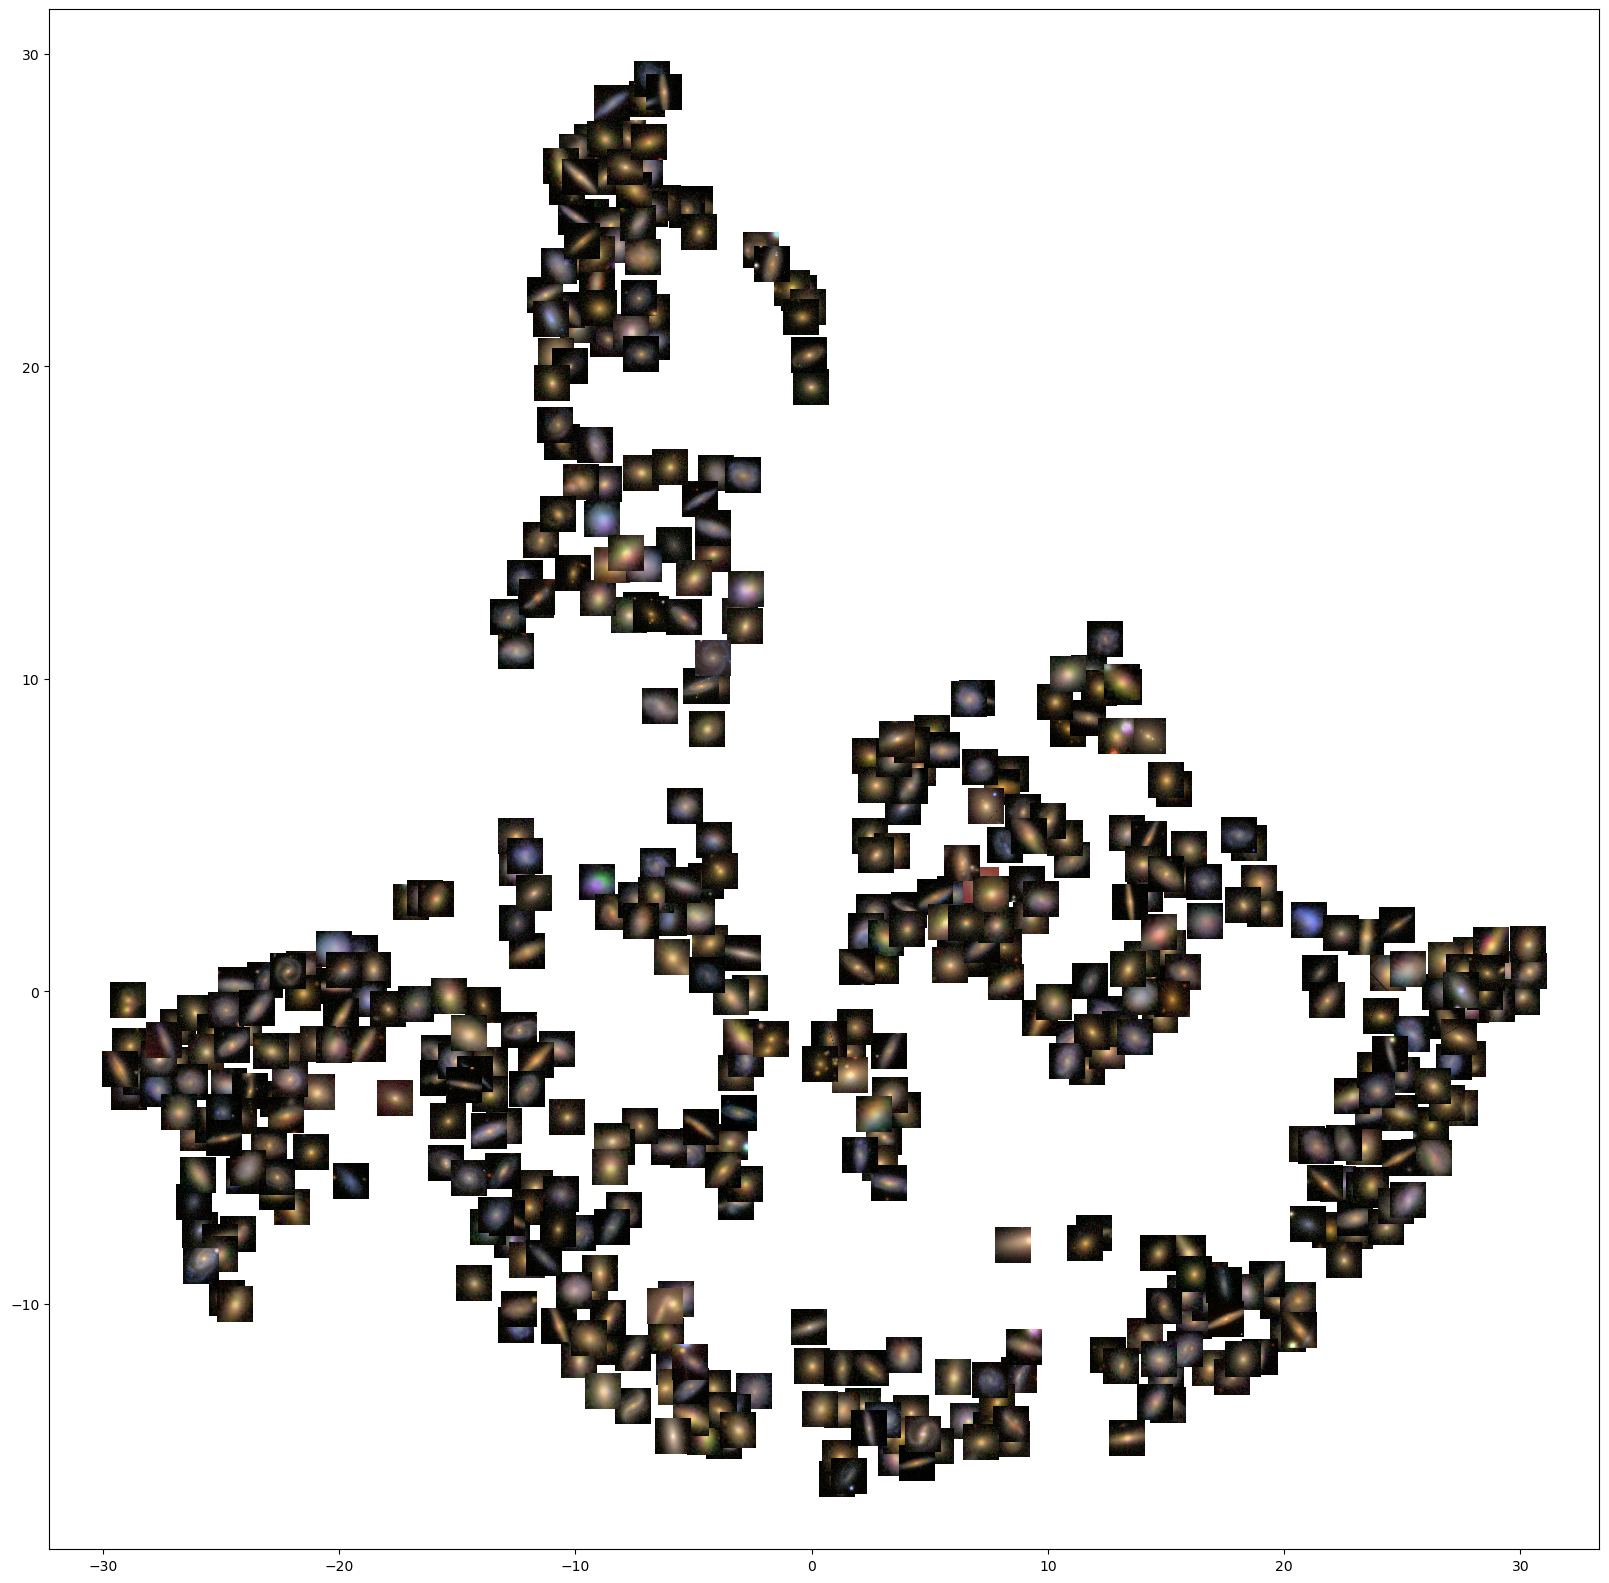

In [257]:
plot_embedding(X_embedded_exp)

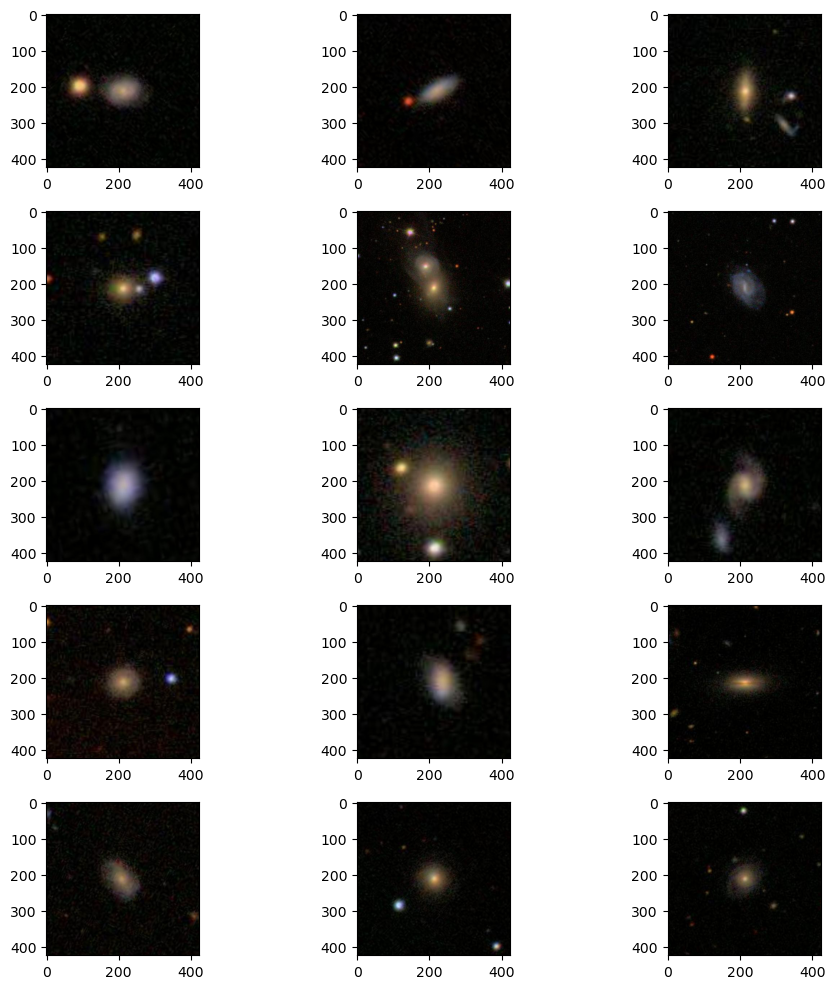

In [80]:
fig = plt.figure(figsize=(10,10))
fnames = filenames[hdb.labels_==3]
for i in range(15):
    ax = fig.add_subplot(5,3,i+1)
    ax.imshow(plt.imread(os.path.join(dirs['source_images'],fnames[i])))
plt.tight_layout()

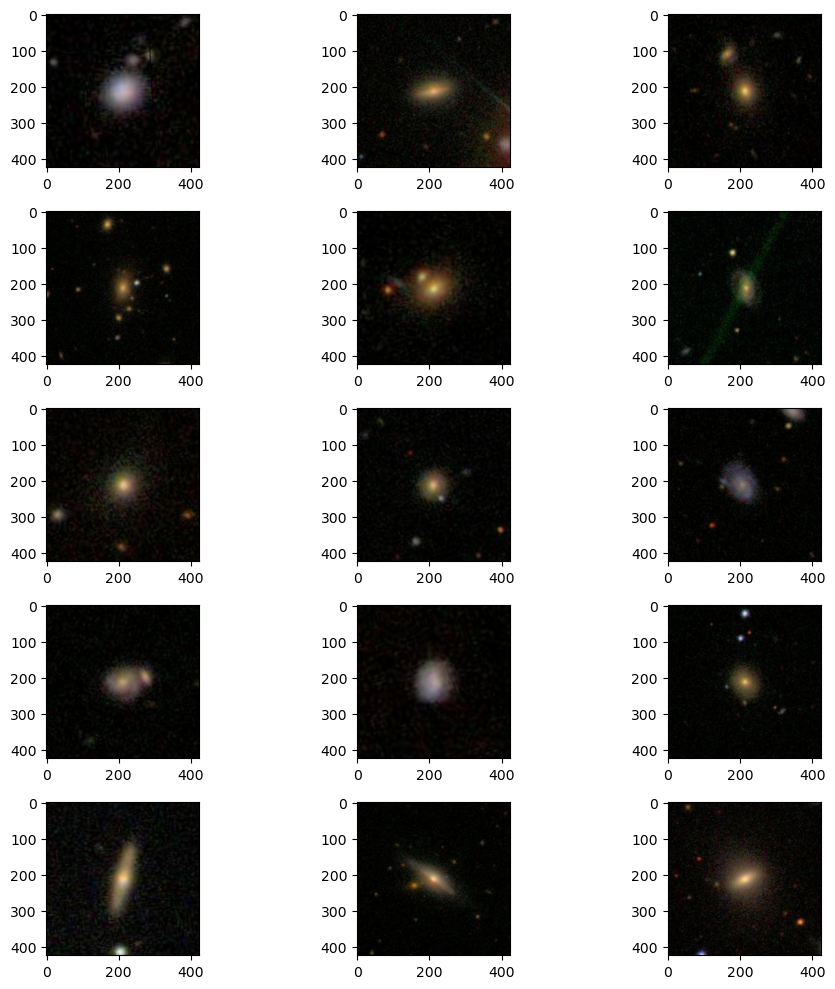

In [81]:
fig = plt.figure(figsize=(10,10))
fnames = filenames[hdb.labels_!=3]
for i in range(15):
    ax = fig.add_subplot(5,3,i+1)
    ax.imshow(plt.imread(os.path.join(dirs['source_images'],fnames[i])))
plt.tight_layout()